## Generación de tabla LUT (Look-Up Table) para estimación de SpO₂

Este notebook recorre automáticamente todos los archivos de señales PPG almacenados en una carpeta, extrae el valor real de SpO₂ desde el nombre de cada archivo, y estima el valor de SpO₂ utilizando una fórmula lineal basada en el ratio de las componentes AC/DC de las señales RED e IR.

### Procedimiento:

1. **Carga de señales**
   - Se recorren archivos csv con nombre en formato "raw_data_XX_YY.csv", donde "YY" representa la SpO2 real medida con un pulsioxímetro comercial.
   - Se validan las columnas necesarias (IR y RED) y se eliminan filas no numéricas o vacías.

2. **Cálculo del ratio óptico**
   - Se calcula el ratio R = (AC_RED/DC_RED)/(AC_IR/DC_IR), donde AC es la desviación típica y DC la media de la señal.

3. **Estimación de SpO₂**
   - Se aplica una fórmula empírica de tipo lineal:
     SPO2 = 95.20 - 0.85 x R
   - Se almacena para cada archivo el valor real, el ratio calculado y la estimación.

4. **Generación de la tabla LUT**
   - Se crea un DataFrame con todos los resultados válidos y se representa gráficamente la comparación entre la SpO2 real y la estimada.


 Registros válidos: 16


,Ratio_R,SpO2_real
0,0.000000,91
1,8.099103,92
2,0.000000,93
3,0.484700,95
4,2.403625,95
5,0.561102,95
6,1.543552,95
7,0.745609,96
8,1.046738,96
9,0.617578,97


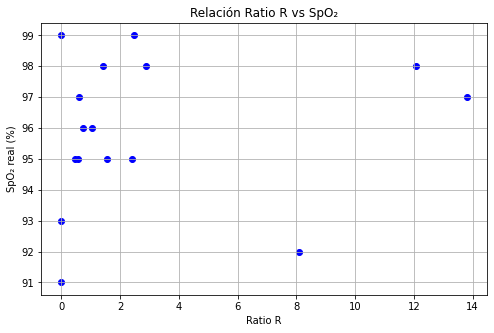

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ruta donde están tus archivos CSV
ruta_archivos = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos_limpios"
registros_lut = []

# Recorrer los archivos de datos
for archivo in os.listdir(ruta_archivos):
    if archivo.endswith(".csv") and archivo.startswith("raw_data_"):
        partes = archivo.replace(".csv", "").split("_")
        
        if len(partes) >= 3:
            try:
                spo2_real = int(partes[2])  # Extraer SpO2 desde el nombre del archivo
                df = pd.read_csv(os.path.join(ruta_archivos, archivo))
                df = df.apply(pd.to_numeric, errors='coerce').dropna()

                # Verificamos que las columnas IR y RED existan
                if "IR" not in df.columns or "RED" not in df.columns:
                    print(f" Columnas IR o RED no encontradas en: {archivo}")
                    continue

                if df["IR"].empty or df["RED"].empty:
                    print(f" Archivo vacío o columnas vacías: {archivo}")
                    continue

                # Cálculo del ratio R
                ac_ir = np.std(df["IR"])
                dc_ir = np.mean(df["IR"])
                ac_red = np.std(df["RED"])
                dc_red = np.mean(df["RED"])

                if dc_ir > 0 and dc_red > 0:
                    R = (ac_red / dc_red) / (ac_ir / dc_ir)
                    registros_lut.append({"Ratio_R": R, "SpO2_real": spo2_real})
            except Exception as e:
                print(f" Error procesando {archivo}: {e}")

# Mostrar resumen
print(f"\n Registros válidos: {len(registros_lut)}")

# Crear DataFrame
tabla_lut = pd.DataFrame(registros_lut)
display(tabla_lut)

# Graficar si hay datos
if not tabla_lut.empty:
    plt.figure(figsize=(8, 5))
    plt.scatter(tabla_lut["Ratio_R"], tabla_lut["SpO2_real"], color='blue')
    plt.xlabel("Ratio R")
    plt.ylabel("SpO₂ real (%)")
    plt.title("Relación Ratio R vs SpO₂")
    plt.grid(True)
    plt.show()
else:
    print(" No se generó la tabla LUT. Revisa si los datos son correctos.")


Nos sale una tabla con valores extrños, como

- Valores de Ratio_R = 0.0:
Esto no es realista fisiológicamente. Probablemente significa que alguna señal IR o RED tenía muy poca variación (AC aproximadamente 0), y se está dividiendo por algo muy pequeño o cercano a cero.

- Algunos ratios exageradamente altos (8, 12, 13...):
Esto puede deberse a señales con mucho ruido o algún error puntual. No es común tener valores tan grandes para el ratio R (típicamente está entre 0.3 y 1.5 para SpO2 normales).

## Filtrar valores extremos o erróneos

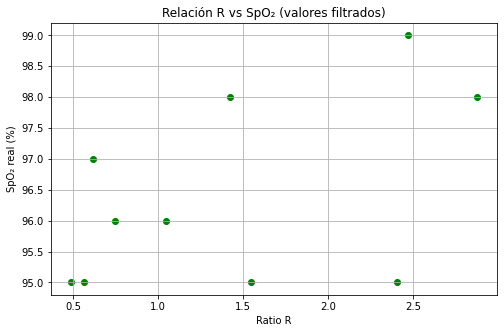

In [3]:
# Filtrar valores razonables de Ratio_R (por ejemplo entre 0.3 y 3.0)
tabla_filtrada = tabla_lut[(tabla_lut["Ratio_R"] > 0.3) & (tabla_lut["Ratio_R"] < 3.5)]

# Visualizar de nuevo
plt.figure(figsize=(8, 5))
plt.scatter(tabla_filtrada["Ratio_R"], tabla_filtrada["SpO2_real"], color='green')
plt.xlabel("Ratio R")
plt.ylabel("SpO₂ real (%)")
plt.title("Relación R vs SpO₂ (valores filtrados)")
plt.grid(True)
plt.show()


## Ajustar una regresión lineal o curva tipo inversa

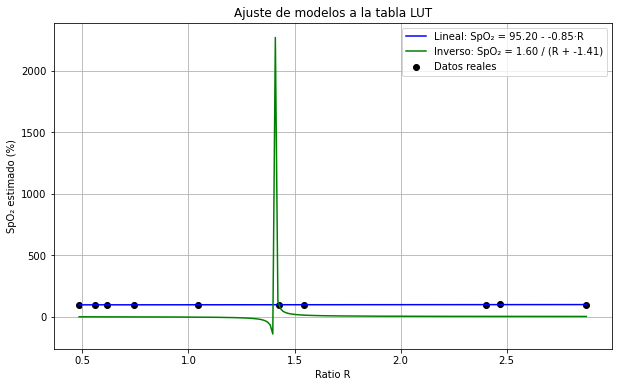

In [4]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Usamos la tabla filtrada (de ratios razonables)
tabla_filtrada = tabla_lut[(tabla_lut["Ratio_R"] > 0.3) & (tabla_lut["Ratio_R"] < 3.5)]

R = tabla_filtrada["Ratio_R"].values
SpO2 = tabla_filtrada["SpO2_real"].values

# Modelo lineal: SpO2 = a - b * R
def modelo_lineal(R, a, b):
    return a - b * R

# Modelo inverso: SpO2 = a / (R + b)
def modelo_inverso(R, a, b):
    return a / (R + b)

# Ajustar ambos modelos
params_lineal, _ = curve_fit(modelo_lineal, R, SpO2)
params_inverso, _ = curve_fit(modelo_inverso, R, SpO2, maxfev=10000)

# Generar valores para graficar
R_vals = np.linspace(min(R), max(R), 200)
SpO2_lineal = modelo_lineal(R_vals, *params_lineal)
SpO2_inverso = modelo_inverso(R_vals, *params_inverso)

# Gráfica comparativa
plt.figure(figsize=(10, 6))
plt.scatter(R, SpO2, label="Datos reales", color='black')
plt.plot(R_vals, SpO2_lineal, label=f"Lineal: SpO₂ = {params_lineal[0]:.2f} - {params_lineal[1]:.2f}·R", color='blue')
plt.plot(R_vals, SpO2_inverso, label=f"Inverso: SpO₂ = {params_inverso[0]:.2f} / (R + {params_inverso[1]:.2f})", color='green')
plt.xlabel("Ratio R")
plt.ylabel("SpO₂ estimado (%)")
plt.title("Ajuste de modelos a la tabla LUT")
plt.legend()
plt.grid(True)
plt.show()



- Puntos negros: sdatos reales (Ratio R medido y SpO₂ real).

- Línea azul (modelo lineal): intenta aproximar esos puntos con una recta.

- Línea verde (modelo inverso): intenta usar una curva más fisiológica, pero ha salido mal

Pero el valor que encontró para b fue negativo (−1.41), y eso causa un problema matemático: cuando R + b se acerca a 0, el resultado se dispara a infinito

Eso explica por qué la curva verde tiene un pico enorme: es un error numérico del ajuste.

Lo que si que funciona es el modelo lineal (linea azul)
SpO₂=95.20−0.85⋅R

Voy a usar esa formula




 Registros válidos: 16


,Archivo,Ratio_R,SpO2_real,SpO2_estimado
0,raw_data_91_91.csv,0.000000,91,95.200000
1,raw_data_92_76.csv,8.099103,92,88.315762
2,raw_data_93_100.csv,0.000000,93,95.200000
3,raw_data_95_77_2.csv,0.484700,95,94.788005
4,raw_data_95_80.csv,2.403625,95,93.156919
5,raw_data_95_81_papa.csv,0.561102,95,94.723063
6,raw_data_95_99.csv,1.543552,95,93.887981
7,raw_data_96_106.csv,0.745609,96,94.566233
8,raw_data_96_69.csv,1.046738,96,94.310273
9,raw_data_97_119.csv,0.617578,97,94.675059


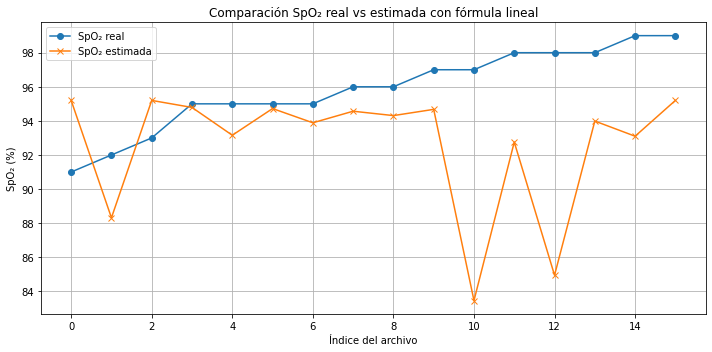

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ruta a tus archivos
ruta_archivos = "C:/Users/Elena/Desktop/GitHub/TFG-Elena-Ruiz/Datos/Datos_limpios"
registros_lut = []

# Recorrer archivos CSV
for archivo in os.listdir(ruta_archivos):
    if archivo.endswith(".csv") and archivo.startswith("raw_data_"):
        partes = archivo.replace(".csv", "").split("_")

        if len(partes) >= 3:
            try:
                spo2_real = int(partes[2])
                df = pd.read_csv(os.path.join(ruta_archivos, archivo), delimiter=",")
                df = df.apply(pd.to_numeric, errors='coerce').dropna()

                if "IR" not in df.columns or "RED" not in df.columns:
                    print(f" Columnas IR o RED no encontradas en: {archivo}")
                    continue

                if df["IR"].empty or df["RED"].empty:
                    print(f"  Archivo vacío o columnas vacías: {archivo}")
                    continue

                # Calcular ratio R
                ac_ir = np.std(df["IR"])
                dc_ir = np.mean(df["IR"])
                ac_red = np.std(df["RED"])
                dc_red = np.mean(df["RED"])

                if dc_ir > 0 and dc_red > 0:
                    R = (ac_red / dc_red) / (ac_ir / dc_ir)

                    # Aplicar fórmula personalizada
                    spo2_estimado = 95.20 - 0.85 * R

                    registros_lut.append({
                        "Archivo": archivo,
                        "Ratio_R": R,
                        "SpO2_real": spo2_real,
                        "SpO2_estimado": spo2_estimado
                    })

            except Exception as e:
                print(f"  Error procesando {archivo}: {e}")

# Crear DataFrame
tabla_lut = pd.DataFrame(registros_lut)

# Mostrar resumen
print(f"\n Registros válidos: {len(tabla_lut)}")
display(tabla_lut[["Archivo", "Ratio_R", "SpO2_real", "SpO2_estimado"]])

# Graficar comparación real vs estimado
if not tabla_lut.empty:
    plt.figure(figsize=(10, 5))
    plt.plot(tabla_lut["SpO2_real"].values, label="SpO₂ real", marker='o')
    plt.plot(tabla_lut["SpO2_estimado"].values, label="SpO₂ estimada", marker='x')
    plt.xlabel("Índice del archivo")
    plt.ylabel("SpO₂ (%)")
    plt.title("Comparación SpO₂ real vs estimada con fórmula lineal")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(" No se generó la tabla LUT. Revisa los datos.")


En esta gráfica se puede ver claramente la saturación de oxígeno real frente la estimada. vemos que en valores de 95,96 y 97% el valor estimado se ajusta al valor esperado, pero en valores más normales como 98 o 99%, no se ajusta tan bien.